# 基于OCRNet的遥感地块分割

# 一、项目背景

>本项目参加 [常规赛：遥感影像地块分割](https://aistudio.baidu.com/aistudio/competition/detail/63/0/introduction)，目前排名为4/365    
  
__常规赛：遥感影像地块分割__ 
  
  
赛题由 2020 CCF BDCI 遥感影像地块分割 初赛赛题改编而来。遥感影像地块分割, 旨在对遥感影像进行像素级内容解析，对遥感影像中感兴趣的类别进行提取和分类，在城乡规划、防汛救灾等领域具有很高的实用价值，在工业界也受到了广泛关注。现有的遥感影像地块分割数据处理方法局限于特定的场景和特定的数据来源，且精度无法满足需求。因此在实际应用中，仍然大量依赖于人工处理，需要消耗大量的人力、物力、财力。本赛题旨在衡量遥感影像地块分割模型在多个类别（如建筑、道路、林地等）上的效果，利用人工智能技术，对多来源、多场景的异构遥感影像数据进行充分挖掘，打造高效、实用的算法，提高遥感影像的分析提取能力。  
  
__赛题任务__  
本赛题旨在对遥感影像进行像素级内容解析，并对遥感影像中的类别进行提取和分类，以衡量遥感影像地块分割模型在多个类别（如建筑、道路、林地等）上的效果。

# 二、数据处理

## 2.1 数据说明：

>数据由比赛主办方提供，包括多个地区已脱敏的遥感影像数据。比赛要求基于这些数据构建地块分割模型。  

### 训练数据集  
  
样例图片及其标注如下图所示：   

  
![](https://ai-studio-static-online.cdn.bcebos.com/8087a965609d48a19a5e60f0330fa9054d04097644de48ffa3d557e7a8ad64ad) ![](https://ai-studio-static-online.cdn.bcebos.com/d18664ecf0514cb686c95958d30bbf8a2f5efb0691bc4d66a5f6317ab511d6d0)    
  
  
![](https://ai-studio-static-online.cdn.bcebos.com/e42f2c222f204094ac3a0ea8582ca331b0452fb2b1704eabaae379d499906977) ![](https://ai-studio-static-online.cdn.bcebos.com/d5260bd5a820486a85aeb2105adfb6fa10284bd94453459f892755bc43e10b8a)  
  
  
训练数据集文件名称：train_and_label.zip

包含2个子文件，分别为：训练数据集（原始图片）文件、训练数据集（标注图片）文件，详细介绍如下：

__训练数据集__（原始图片）文件名称：img_train

包含66,653张分辨率为2m/pixel，尺寸为256 * 256的JPG图片，每张图片的名称形如T000123.jpg。

__训练数据集__（标注图片）文件名称：lab_train

包含66,653张分辨率为2m/pixel，尺寸为256 * 256的PNG图片，每张图片的名称形如T000123.png。

__备注__： 全部PNG图片共包括4种分类，像素值分别为0、1、2、3。此外，像素值255为未标注区域，表示对应区域的所属类别并不确定，在评测中也不会考虑这部分区域。

### 测试数据集
测试数据集文件名称：img_test.zip，详细介绍如下：

包含4,609张分辨率为2m/pixel，尺寸为256 * 256的JPG图片，文件名称形如123.jpg。、

数据增强工具



## 2.2 数据加载

In [ ]:
#解压数据
! unzip -oq /home/aistudio/data/data80164/train_and_label.zip -d /home/aistudio/dataset
! unzip -oq /home/aistudio/data/data80164/img_test.zip -d /home/aistudio/dataset

In [ ]:
# 目录结构
! tree ./dataset -d

./dataset
├── datatrans
├── img_testA
├── img_train
├── lab_train
└── __MACOSX
    └── img_testA

6 directories


## 2.3 灰度标注转换为伪彩色标注

一般的分割库使用单通道灰度图作为标注图片，往往显示出来是全黑的效果。  
  
无法直接观察标注是否正确；模型测试过程无法直接判断分割的实际效果。  
   
为了显示标注结果，将灰色标注转换为伪彩色标注

In [ ]:
import cv2
import numpy as np

In [ ]:
! python PaddleSeg/tools/gray2pseudo_color.py 'dataset/lab_train' 'dataset/datatrans'

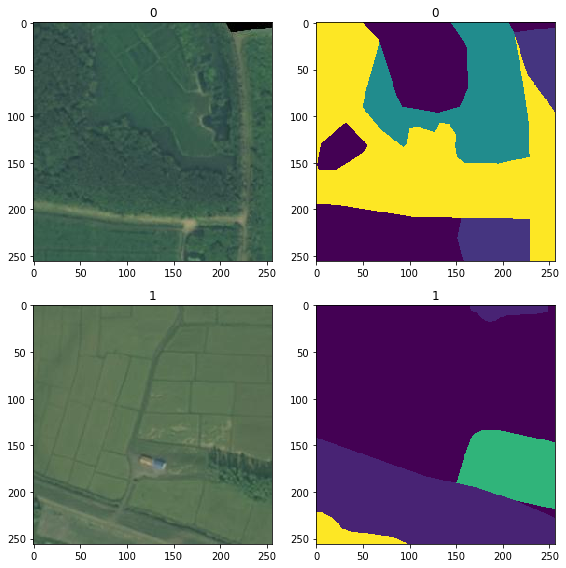

In [ ]:
# 选取4张图片进行展示
import cv2
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False #显示负号
%matplotlib inline

image_path_list = ['dataset/img_train/T068241.jpg', 'dataset/img_train/T050382.jpg']
label_path_list = ['dataset/datatrans/T068241.png', 'dataset/datatrans/T050382.png']

plt.figure(figsize=(8, 8))
for i in range(len(image_path_list)):
    plt.subplot(len(image_path_list), 2, i*2+1)
    plt.title(i) 
    plt.imshow(cv2.imread(image_path_list[i])[:, :, ::-1])

    plt.subplot(len(image_path_list), 2, i*2+2)
    plt.title(i)
    plt.imshow(cv2.imread(label_path_list[i], cv2.IMREAD_GRAYSCALE)) #cv2 imread 非空
plt.tight_layout()
plt.show()

## 2.4 图像数据的统计分析

In [ ]:
# 计算图像数据整体均值和方差
import glob
import cv2

def get_mean_std(image_path_list):
    print('Total images:', len(image_path_list))
    max_val, min_val = np.zeros(3), np.ones(3) * 255
    mean, std = np.zeros(3), np.zeros(3)
    for image_path in image_path_list:
        image = cv2.imread(image_path)
        for c in range(3):
            mean[c] += image[:, :, c].mean()
            std[c] += image[:, :, c].std()
            max_val[c] = max(max_val[c], image[:, :, c].max())
            min_val[c] = min(min_val[c], image[:, :, c].min())

    mean /= len(image_path_list) #均值
    std /= len(image_path_list)  #标准差

    mean /= max_val - min_val
    std /= max_val - min_val

    return mean, std
mean, std = get_mean_std(glob.glob('dataset/img_train/*.jpg'))
print('mean:', mean)
print('std:', std)

## 2.5 生成训练文件

In [ ]:
import os
import random
import numpy as np

In [ ]:
# 四类标签，这里用处不大，比赛评测是以0、1、2、3类来对比评测的
labels = ['建筑', '耕地', '林地',  '其他']

# 将labels写入标签文件
with open('labels.txt', 'w') as f:
    for v in labels:
        f.write(v+'\n')

In [ ]:
import os
import numpy as np

datas = []
image_base = '/home/aistudio/dataset/img_train'   # 训练集原图路径
annos_base = '/home/aistudio/dataset/datatrans'   # 训练集标签路径

# 读取原图文件名
ids_ = [v.split('.')[0] for v in os.listdir(image_base)]

# 将训练集的图像集和标签路径写入datas中
for id_ in ids_:
    img_pt0 = os.path.join(image_base, '{}.jpg'.format(id_))
    img_pt1 = os.path.join(annos_base, '{}.png'.format(id_))
    datas.append((img_pt0.replace('/home/aistudio', ''), img_pt1.replace('/home/aistudio', '')))
    if os.path.exists(img_pt0) and os.path.exists(img_pt1):
        pass
    else:
        raise "path invalid!"

In [ ]:
import os
train_val_ratio = 0.8 #训练集和验证集划分比例
train_data_dir = os.listdir('dataset/img_train')
train_data_dir_num = len(train_data_dir)
train_data_num = int(train_data_dir_num * train_val_ratio)
train_data = train_data_dir[0:train_data_num]
val_data = train_data_dir[train_data_num:]

#生成训练集文件
for t in range(len(train_data)):
    train_image = os.path.join('img_train',train_data[t])
    train_label = train_image.replace("img_train","datatrans").replace("jpg","png")
    with open("./trainlist.txt","a+") as train_file:
        train_file.write("%s %s\n"%(train_image,train_label))

#生成验证集文件
for v in range(len(val_data)):
    val_image = os.path.join('img_train',val_data[v])
    val_label = val_image.replace("img_train","datatrans").replace("jpg","png")
    with open("./vallist.txt","a+") as val_file:
        val_file.write("%s %s\n"%(val_image,val_label))

In [ ]:
# 随机打乱datas
np.random.seed(5)
np.random.shuffle(datas)

# 验证集与训练集的划分，0.05表示5%为训练集，95%为训练集
split_num = int(0.05*len(datas))

# 划分训练集和验证集
train_data = datas[:-split_num]
valid_data = datas[-split_num:]

# 写入训练集list
with open('train_list.txt', 'w') as f:
    for img, lbl in train_data:
        f.write(img + ' ' + lbl + '\n')

# 写入验证集list
with open('valid_list.txt', 'w') as f:
    for img, lbl in valid_data:
        f.write(img + ' ' + lbl + '\n')

# 打印训练集和测试集大小
print('train:', len(train_data))
print('valid:', len(valid_data))

# 三、 模型训练

## 3.1 模型配置

### 3.1.1 分割网络  
### __OCRNet__  

FCN（Fully Convolutional Network for Semantic Segmentation）可以对图像进行像素级的分类，解决了语义级别的图像分割问题，因此现有的大多数语义分割方法都基于FCN。但这些方法也有一定缺陷，比如分辨率低、上下文信息缺失和边界错误等。2020年，相关学者为解决语义分割上下文信息缺失难题，建设性地提出OCRNet，即基于物体上下文特征表示（Object Contextual Representation，以下简称OCR）的网络框架。其整体结构如下所示：  
  
![](https://ai-studio-static-online.cdn.bcebos.com/c2fe98e4ed81462f95fa057e5b112166cce6bcc76b5b455ca491d2dd0c4b5cc0)
 
 
  
实现此OCR方法需要经历三个阶段——首先形成软物体区域（Soft Object Regions），然后计算物体区域表示（Object Region Representations），最后得到物体上下文特征表示和上下文信息增强的特征表示（Augmented Representation）。 与其他语义分割方法相比，OCR方法更加高效准确。因为OCR方法解决的是物体区域分类问题，而非像素分类问题，即OCR方法可以有效地、显式地增强物体信息。从性能和复杂度来说，OCRNet也更为优秀。2020年，“HRNet + OCR + SegFix”版本在2020ECCV Cityscapes 获得了第一名。

### 3.1.2  骨干网络  
  
### __HRNet__  
  
HRNet（HighResolution Net）能够在整个过程中保持高分辨率表示。如图5所示，HRNet以高分辨率子网开始作为第一阶段，逐个添加高到低分辨率子网以形成更多阶段，并且并行连接多分辨率子网。在整个过程中反复交换并行多分辨率子网络中的信息来进行重复的多尺度融合。在像素级分类、区域级分类和图像级分类中，证明了这些方法的有效性。 HRNet具有两个特点：

从高分辨率到低分辨率并行连接各子网络。
反复交换跨分辨率子网络信息。
这两个特点使HRNet网络能够学习到更丰富的语义信息和细节信息。 HRNet在人体姿态估计、语义分割和目标检测领域都取得了显著的性能提升。 HRNet结构图如下所示：    


  
 ![](https://ai-studio-static-online.cdn.bcebos.com/fcd7f847e9d14f29a79abd7685df12ede2ec9d1a9aa742ddbf6291e3e248b5a7)  
   


In [ ]:
# 模型配置如下所示：
model:
  type: OCRNet #模型
  backbone: #backbone选择HRNet
    type: HRNet_W48
    align_corners: False
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/hrnet_w48_ssld.tar.gz
  backbone_indices: [-1]
  pretrained: https://bj.bcebos.com/paddleseg/dygraph/ccf/fcn_hrnetw48_rs_256x256_160k/model.pdparams #加载预训练模型

### 3.1.3 评测指标  
  
使用国际通用指标平均交并比MIoU，记真实值为i，预测为j的像素数量为pij，则MIoU的具体计算公式为：  
  
![](https://ai-studio-static-online.cdn.bcebos.com/b0b650b04b8941e8b840a31e018f5b0ddf8b0d320f864c8192e21bed42ab4cea)


## 3.2 数据集配置与数据增强

In [ ]:
train_dataset:
  type: Dataset #因为是自定义数据集，继承官方的Dataset类
  dataset_root: ./dataset #数据集图片文件夹路径
  train_path: ./trainlist.txt #训练集文件列表
  num_classes: 4 #分类数量
  transforms:
    - type: Resize
      target_size: [256, 256]
    - type: RandomHorizontalFlip
    - type: Normalize
  mode: train

val_dataset:
  type: Dataset
  dataset_root: ./dataset
  val_path: ./vallist.txt #验证集文件列表
  num_classes: 4
  transforms:
    - type: Resize
      target_size: [256, 256]
    - type: RandomHorizontalFlip
    - type: Normalize
  mode: val

## 3.3 学习率和优化器配置

### 3.3.1 学习率
根据经验，学习率采取按多项式衰减的策略  
  
![](https://ai-studio-static-online.cdn.bcebos.com/962ce8d407d043fb81e0b2b09cd8eef1afb62f589b974f6c8543b2ee06d47253)  


### 3.3.2. 优化器
选择随机梯度下降算法的优化器  
  
![](https://ai-studio-static-online.cdn.bcebos.com/7dfcc598f6f64188a12decdf1a9e0fa55e8f4cc746624391826740151db9a486)  
  
为网络添加反向计算过程，并根据反向计算所得的梯度，更新parameters中的Parameters，最小化网络损失值loss。

In [ ]:
# 学习率和优化器配置如下:
lr_scheduler:
  end_lr: 0
  learning_rate: 0.0025
  power: 0.9
  type: PolynomialDecay

optimizer:
  momentum: 0.9
  type: sgd
  weight_decay: 4.0e-05

## 3.4 损失函数配置

使用交叉熵函数作为损失函数

In [ ]:
损失函数配置如下：
loss:
  coef:
  - 1
  - 0.4
  types:
  - type: CrossEntropyLoss

## 3.5 开始训练

### 3.5.1 环境配置

In [ ]:
! /opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip --user
! pip install paddleseg

In [ ]:
! git clone https://gitee.com/paddlepaddle/PaddleSeg.git

In [ ]:
from paddle.io import Dataset

### 3.5.2 开始训练

由于样本数较大，分开了多次训练

In [ ]:
! python PaddleSeg/train.py --config PaddleSeg/configs/orc_train01.yml --do_eval --use_vdl --save_interval 200 --save_dir output

2022-03-10 06:24:10 [INFO]	
------------Environment Information-------------
platform: Linux-4.4.0-150-generic-x86_64-with-debian-stretch-sid
Python: 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
Paddle compiled with cuda: True
NVCC: Cuda compilation tools, release 10.1, V10.1.243
cudnn: 7.6
GPUs used: 1
CUDA_VISIBLE_DEVICES: None
GPU: ['GPU 0: Tesla V100-SXM2-32GB']
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~16.04) 7.5.0
PaddleSeg: 2.4.0
PaddlePaddle: 2.2.2
OpenCV: 4.1.1
------------------------------------------------
2022-03-10 06:24:11 [INFO]	
---------------Config Information---------------
batch_size: 10
iters: 6666
loss:
  coef:
  - 1
  - 0.4
  types:
  - ignore_index: 255
    type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.0025
  power: 0.9
  type: PolynomialDecay
model:
  backbone:
    align_corners: false
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/hrnet_w48_ssld.tar.gz
    type: HRNet_W48
  backbone_indices:
  - -1
  pretrained: https://bj.bcebos.co

In [ ]:
! python PaddleSeg/train.py --config PaddleSeg/configs/orc_train01.yml --resume_model output/iter_1000 --do_eval --use_vdl --save_interval 200 --save_dir output

2022-03-10 08:24:29 [INFO]	
------------Environment Information-------------
platform: Linux-4.4.0-150-generic-x86_64-with-debian-stretch-sid
Python: 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
Paddle compiled with cuda: True
NVCC: Cuda compilation tools, release 10.1, V10.1.243
cudnn: 7.6
GPUs used: 1
CUDA_VISIBLE_DEVICES: None
GPU: ['GPU 0: Tesla V100-SXM2-32GB']
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~16.04) 7.5.0
PaddleSeg: 2.4.0
PaddlePaddle: 2.2.2
OpenCV: 4.1.1
------------------------------------------------
2022-03-10 08:24:30 [INFO]	
---------------Config Information---------------
batch_size: 10
iters: 6666
loss:
  coef:
  - 1
  - 0.4
  types:
  - ignore_index: 255
    type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.0025
  power: 0.9
  type: PolynomialDecay
model:
  backbone:
    align_corners: false
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/hrnet_w48_ssld.tar.gz
    type: HRNet_W48
  backbone_indices:
  - -1
  pretrained: https://bj.bcebos.co

In [ ]:
! python PaddleSeg/train.py --config PaddleSeg/configs/orc_train01.yml --resume_model output/iter_4200 --do_eval --use_vdl --save_interval 200 --save_dir output

2022-03-10 20:25:20 [INFO]	
------------Environment Information-------------
platform: Linux-4.4.0-150-generic-x86_64-with-debian-stretch-sid
Python: 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
Paddle compiled with cuda: True
NVCC: Cuda compilation tools, release 10.1, V10.1.243
cudnn: 7.6
GPUs used: 1
CUDA_VISIBLE_DEVICES: None
GPU: ['GPU 0: Tesla V100-SXM2-32GB']
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~16.04) 7.5.0
PaddleSeg: 2.4.0
PaddlePaddle: 2.2.2
OpenCV: 4.1.1
------------------------------------------------
2022-03-10 20:25:21 [INFO]	
---------------Config Information---------------
batch_size: 10
iters: 6666
loss:
  coef:
  - 1
  - 0.4
  types:
  - ignore_index: 255
    type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.0025
  power: 0.9
  type: PolynomialDecay
model:
  backbone:
    align_corners: false
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/hrnet_w48_ssld.tar.gz
    type: HRNet_W48
  backbone_indices:
  - -1
  pretrained: https://bj.bcebos.co

In [ ]:
! python PaddleSeg/train.py --config PaddleSeg/configs/orc_train01.yml --resume_model output/iter_4800 --do_eval --use_vdl --save_interval 200 --save_dir output

2022-03-10 22:28:36 [INFO]	
------------Environment Information-------------
platform: Linux-4.4.0-150-generic-x86_64-with-debian-stretch-sid
Python: 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
Paddle compiled with cuda: True
NVCC: Cuda compilation tools, release 10.1, V10.1.243
cudnn: 7.6
GPUs used: 1
CUDA_VISIBLE_DEVICES: None
GPU: ['GPU 0: Tesla V100-SXM2-32GB']
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~16.04) 7.5.0
PaddleSeg: 2.4.0
PaddlePaddle: 2.2.2
OpenCV: 4.1.1
------------------------------------------------
2022-03-10 22:28:37 [INFO]	
---------------Config Information---------------
batch_size: 10
iters: 6666
loss:
  coef:
  - 1
  - 0.4
  types:
  - ignore_index: 255
    type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.0025
  power: 0.9
  type: PolynomialDecay
model:
  backbone:
    align_corners: false
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/hrnet_w48_ssld.tar.gz
    type: HRNet_W48
  backbone_indices:
  - -1
  pretrained: https://bj.bcebos.co

In [ ]:
! python PaddleSeg/train.py --config PaddleSeg/configs/orc_train01.yml --resume_model output/iter_5400 --do_eval --use_vdl --save_interval 200 --save_dir output

2022-03-10 23:58:40 [INFO]	Loading pretrained model from https://bj.bcebos.com/paddleseg/dygraph/hrnet_w48_ssld.tar.gz
2022-03-10 23:58:43 [INFO]	There are 1525/1525 variables loaded into HRNet.
2022-03-10 23:58:43 [INFO]	Loading pretrained model from https://bj.bcebos.com/paddleseg/dygraph/ccf/fcn_hrnetw48_rs_256x256_160k/model.pdparams
2022-03-10 23:58:45 [WARNING]	head.spatial_ocr.attention_block.f_pixel.0._conv.weight is not in pretrained model
2022-03-10 23:58:45 [WARNING]	head.spatial_ocr.attention_block.f_pixel.0._conv.bias is not in pretrained model
2022-03-10 23:58:45 [WARNING]	head.spatial_ocr.attention_block.f_pixel.0._batch_norm.weight is not in pretrained model
2022-03-10 23:58:45 [WARNING]	head.spatial_ocr.attention_block.f_pixel.0._batch_norm.bias is not in pretrained model
2022-03-10 23:58:45 [WARNING]	head.spatial_ocr.attention_block.f_pixel.0._batch_norm._mean is not in pretrained model
2022-03-10 23:58:45 [WARNING]	head.spatial_ocr.attention_block.f_pixel.0._batch_no

In [ ]:
! python PaddleSeg/train.py --config PaddleSeg/configs/orc_train01.yml --resume_model output/iter_6000 --do_eval --use_vdl --save_interval 200 --save_dir output

2022-03-11 01:51:30 [INFO]	
------------Environment Information-------------
platform: Linux-4.4.0-150-generic-x86_64-with-debian-stretch-sid
Python: 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
Paddle compiled with cuda: True
NVCC: Cuda compilation tools, release 10.1, V10.1.243
cudnn: 7.6
GPUs used: 1
CUDA_VISIBLE_DEVICES: None
GPU: ['GPU 0: Tesla V100-SXM2-32GB']
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~16.04) 7.5.0
PaddleSeg: 2.4.0
PaddlePaddle: 2.2.2
OpenCV: 4.1.1
------------------------------------------------
2022-03-11 01:51:31 [INFO]	
---------------Config Information---------------
batch_size: 10
iters: 6666
loss:
  coef:
  - 1
  - 0.4
  types:
  - ignore_index: 255
    type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.0025
  power: 0.9
  type: PolynomialDecay
model:
  backbone:
    align_corners: false
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/hrnet_w48_ssld.tar.gz
    type: HRNet_W48
  backbone_indices:
  - -1
  pretrained: https://bj.bcebos.co

In [ ]:
! python PaddleSeg/train.py --config PaddleSeg/configs/orc_train01.yml --resume_model output/iter_6600 --do_eval --use_vdl --save_interval 66 --save_dir output

2022-03-11 05:11:32 [INFO]	
------------Environment Information-------------
platform: Linux-4.4.0-150-generic-x86_64-with-debian-stretch-sid
Python: 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
Paddle compiled with cuda: True
NVCC: Cuda compilation tools, release 10.1, V10.1.243
cudnn: 7.6
GPUs used: 1
CUDA_VISIBLE_DEVICES: None
GPU: ['GPU 0: Tesla V100-SXM2-32GB']
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~16.04) 7.5.0
PaddleSeg: 2.4.0
PaddlePaddle: 2.2.2
OpenCV: 4.1.1
------------------------------------------------
2022-03-11 05:11:33 [INFO]	
---------------Config Information---------------
batch_size: 10
iters: 6666
loss:
  coef:
  - 1
  - 0.4
  types:
  - ignore_index: 255
    type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.0025
  power: 0.9
  type: PolynomialDecay
model:
  backbone:
    align_corners: false
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/hrnet_w48_ssld.tar.gz
    type: HRNet_W48
  backbone_indices:
  - -1
  pretrained: https://bj.bcebos.co

# 四、模型评估与测试

## 4.1 模型评估

In [ ]:
! python PaddleSeg/val.py --config PaddleSeg/configs/orc_train01.yml --model_path output/best_model/model.pdparams

2022-03-11 05:38:48 [INFO]	
---------------Config Information---------------
batch_size: 10
iters: 6666
loss:
  coef:
  - 1
  - 0.4
  types:
  - type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.0025
  power: 0.9
  type: PolynomialDecay
model:
  backbone:
    align_corners: false
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/hrnet_w48_ssld.tar.gz
    type: HRNet_W48
  backbone_indices:
  - -1
  pretrained: https://bj.bcebos.com/paddleseg/dygraph/ccf/fcn_hrnetw48_rs_256x256_160k/model.pdparams
  type: OCRNet
optimizer:
  momentum: 0.9
  type: sgd
  weight_decay: 4.0e-05
train_dataset:
  dataset_root: ./dataset
  mode: train
  num_classes: 4
  train_path: ./trainlist.txt
  transforms:
  - target_size:
    - 256
    - 256
    type: Resize
  - type: RandomHorizontalFlip
  - type: Normalize
  type: Dataset
val_dataset:
  dataset_root: ./dataset
  mode: val
  num_classes: 4
  transforms:
  - target_size:
    - 256
    - 256
    type: Resize
  - type: RandomHorizon

>可以看出，在迭代训练后4个分类的IoU分别是0.5926 0.6787 0.5407 0.4477，mIoU为0.5649  
4个分类的Acc 分别是 0.7287 0.8401 0.7055 0.5933，Acc为0.7357    
训练取得不错的效果。

## 4.2 模型测试

In [ ]:
! python PaddleSeg/predict.py --config PaddleSeg/configs/orc_train01.yml --model_path output/best_model/model.pdparams --image_path ./dataset/img_testA --save_dir ./result

2022-03-11 06:21:49 [INFO]	
---------------Config Information---------------
batch_size: 10
iters: 6666
loss:
  coef:
  - 1
  - 0.4
  types:
  - type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.0025
  power: 0.9
  type: PolynomialDecay
model:
  backbone:
    align_corners: false
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/hrnet_w48_ssld.tar.gz
    type: HRNet_W48
  backbone_indices:
  - -1
  pretrained: https://bj.bcebos.com/paddleseg/dygraph/ccf/fcn_hrnetw48_rs_256x256_160k/model.pdparams
  type: OCRNet
optimizer:
  momentum: 0.9
  type: sgd
  weight_decay: 4.0e-05
train_dataset:
  dataset_root: ./dataset
  mode: train
  num_classes: 4
  train_path: ./trainlist.txt
  transforms:
  - target_size:
    - 256
    - 256
    type: Resize
  - type: RandomHorizontalFlip
  - type: Normalize
  type: Dataset
val_dataset:
  dataset_root: ./dataset
  mode: val
  num_classes: 4
  transforms:
  - target_size:
    - 256
    - 256
    type: Resize
  - type: RandomHorizon

In [ ]:
# 结果压缩并提交 ! zip -r result.zip ./result

将此结果提交至常规赛：[遥感影像地块分割](https://aistudio.baidu.com/aistudio/competition/detail/63/0/introduction)，排名4/365 

相信通过适当修改调整训练数据的增强参数以及迭代次数的增加，效果还能有提升。 

比赛排名：__排名4/365__ 


![](https://ai-studio-static-online.cdn.bcebos.com/8197b844381c4ac9a679df1ef12ec0a784c00a4860a74dc2b3a55ad5ea0a9816) 



# 五、总结与优化

__成果__  
   

本次训练取得不错的效果：  
  
在迭代训练后4个分类的IoU分别是0.5926 0.6787 0.5407 0.4477，mIoU为0.5649  
  
  
4个分类的Acc 分别是 0.7287 0.8401 0.7055 0.5933，Acc为0.7357    
  
 
 
在[遥感影像地块分割比赛](https://aistudio.baidu.com/aistudio/competition/detail/63/0/introduction)中排名4/365 
 
__优化方向__  
  
采取数据增强工具，优化模型

PaTTA： 由第三方开发者组织AgentMaker维护的Test-Time Augmentation（TTA）库，可在测试时通过数据增强方式产生额外的推理结果，在此基础上进行投票即可获得更优秀的比赛成绩表现。
https://github.com/AgentMaker/PaTTA

RIFLE： 由第三方开发者组织AgentMaker对ICML 2020中的《RIFLE: Backpropagation in Depth for Deep Transfer Learning through Re-Initializing the Fully-connected LayEr》论文所提供的封装版本，通过对输出层多次重新初始化来使得深层backbone得到更充分的更新，从而获得成绩提升的潜力。
https://github.com/AgentMaker/RIFLE_Module